In [31]:
import re
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
import snscrape.modules.twitter as sntwitter

In [32]:
result1 = pd.read_csv("LIWC-22 Results - tweets1 - LIWC Analysis.csv", index_col=0)
result1 = result1.iloc[:,1:]
result2 = pd.read_csv("LIWC-22 Results - tweets2 - LIWC Analysis.csv", index_col=0)
result2 = result2.rename(columns={"just_date":"Date"})

In [33]:
temp1 = result1.drop(['Datetime', 'RawText','Text','Tweet Id','Username','replyCount','replyCount','Affect'], axis=1).groupby(by=["Date"]).sum()
temp2 = result2.drop(['Datetime', 'RawText','Text','Tweet Id','Username','replyCount','replyCount','Affect'], axis=1).groupby(by=["Date"]).sum()
total = pd.concat([temp1, temp2], axis=0)
total = total.rename({'Segment': 'Tweet Number'}, axis=1)

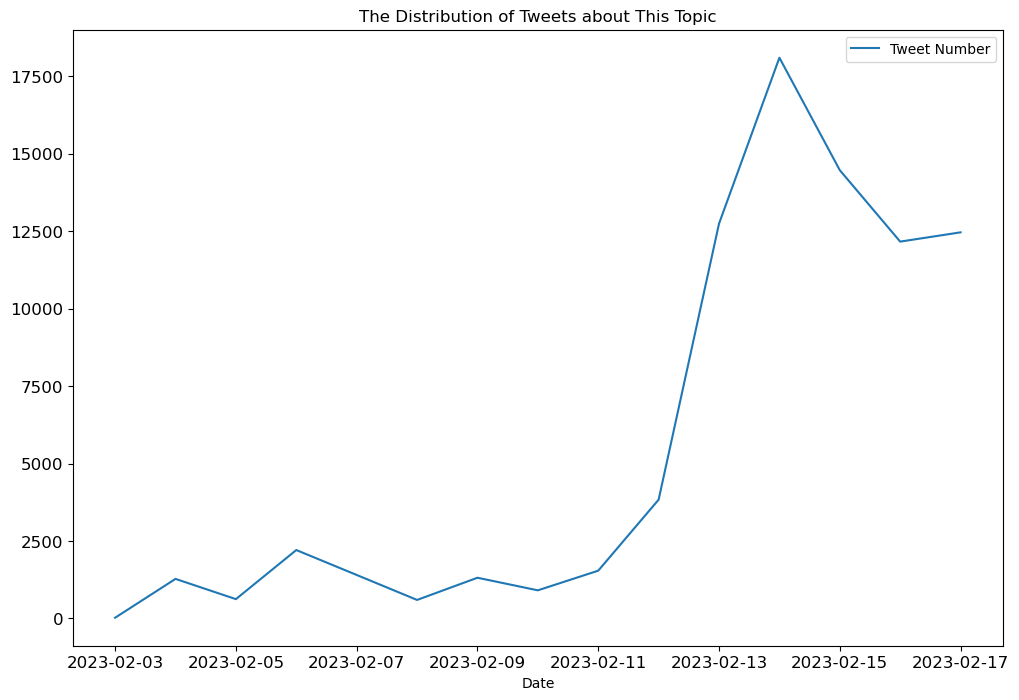

In [34]:
lines2 = total.plot.line( y=['Tweet Number'],figsize=(12,8),fontsize=12,title='The Distribution of Tweets about This Topic')

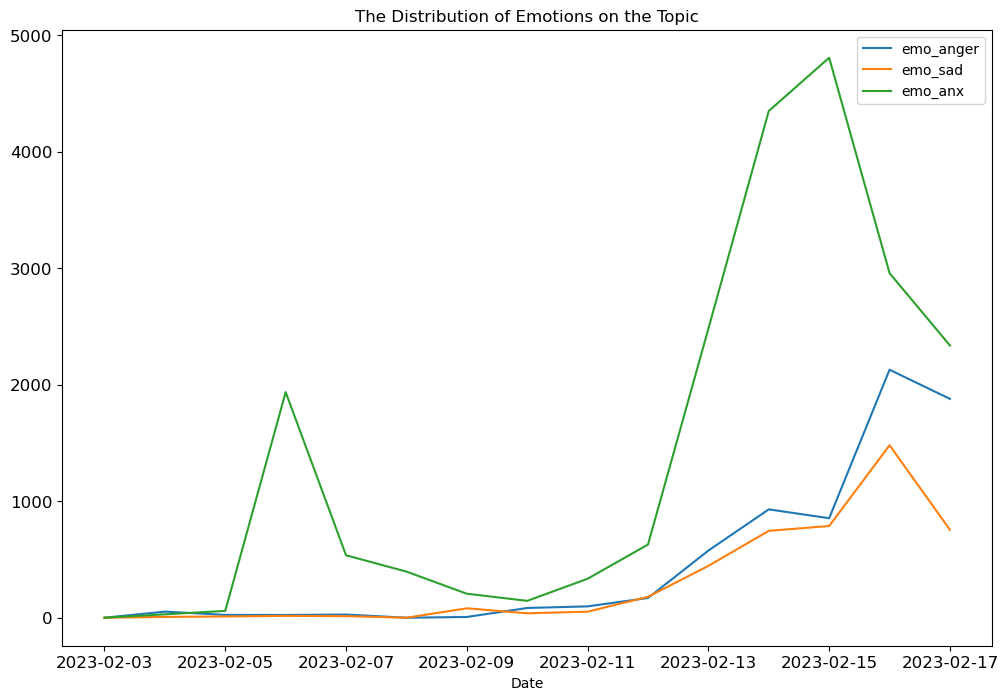

In [35]:
lines = total.plot.line( y=['emo_anger','emo_sad','emo_anx'],figsize=(12,8),fontsize=12,title='The Distribution of Emotions on the Topic')

In [36]:
data = pd.concat([result1,result2],ignore_index=True)

In [37]:
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [38]:
max_x = data.loc[data['replyCount'].idxmax()]

In [39]:
def process_text(text):
    res=[]
    words=text.split()
    for i in range(len(words)):
        if '@' in words[i]:
            res.append(words[i][1:])
        else:
            break
    return res

In [40]:
def find_reply_to_user(time,user,con_id):
    count=0
    name='@'+str(user)
    date=str(time.year)+'-'+str(time.month)+'-'+str(time.day)
    date2=time+timedelta(days=1)
    date3=date2+timedelta(days=1)
    date2=str(date2.year)+'-'+str(date2.month)+'-'+str(date2.day)
    date3=str(date3.year)+'-'+str(date3.month)+'-'+str(date3.day)    
    total_search1=name+' since:'+str(date)+' until:'+date2
    total_search2=name+' since:'+str(date2)+' until:'+date3
    Exact_time=[]
    sender=[]
    receiver=[]
    print(total_search1,con_id)
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(total_search1).get_items()): #declare a username 
        if i>15000:#number of tweets you want to scrape
            break
        if tweet.conversationId==int(con_id):
            count=count+1
            sender.append(tweet.user.username)
            receiver.append(process_text(tweet.rawContent))
            Exact_time.append(tweet.date)
    for j,tweet in enumerate(sntwitter.TwitterSearchScraper(total_search2).get_items()): #declare a username 
        if j>15000:
            print('max reached: ',count,' The con_id is ',con_id)#number of tweets you want to scrape
            break
        if tweet.conversationId==int(con_id):
            count=count+1
            sender.append(tweet.user.username)
            receiver.append(process_text(tweet.rawContent))
            Exact_time.append(tweet.date)
    return sender,receiver,Exact_time

In [41]:
a,b,c=find_reply_to_user(max_x['Datetime'],'RepMTG',1624910190847094784)

@RepMTG since:2023-2-12 until:2023-2-13 1624910190847094784


C:\Users\Jayden\AppData\Local\Temp\ipykernel_26908\3320258704.py:21: FutureWarning: content is deprecated, use rawContent instead
  receiver.append(process_text(tweet.content))
C:\Users\Jayden\AppData\Local\Temp\ipykernel_26908\3320258704.py:30: FutureWarning: content is deprecated, use rawContent instead
  receiver.append(process_text(tweet.content))


max reached:  3491  The con_id is  1624910190847094784


C:\Users\Jayden\AppData\Local\Temp\ipykernel_26908\3871513296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comment_network = comment_network.append(new_row, ignore_index=True)
C:\Users\Jayden\AppData\Local\Temp\ipykernel_26908\3871513296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comment_network = comment_network.append(new_row, ignore_index=True)
C:\Users\Jayden\AppData\Local\Temp\ipykernel_26908\3871513296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comment_network = comment_network.append(new_row, ignore_index=True)
C:\Users\Jayden\AppData\Local\Temp\ipykernel_26908\3871513296.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

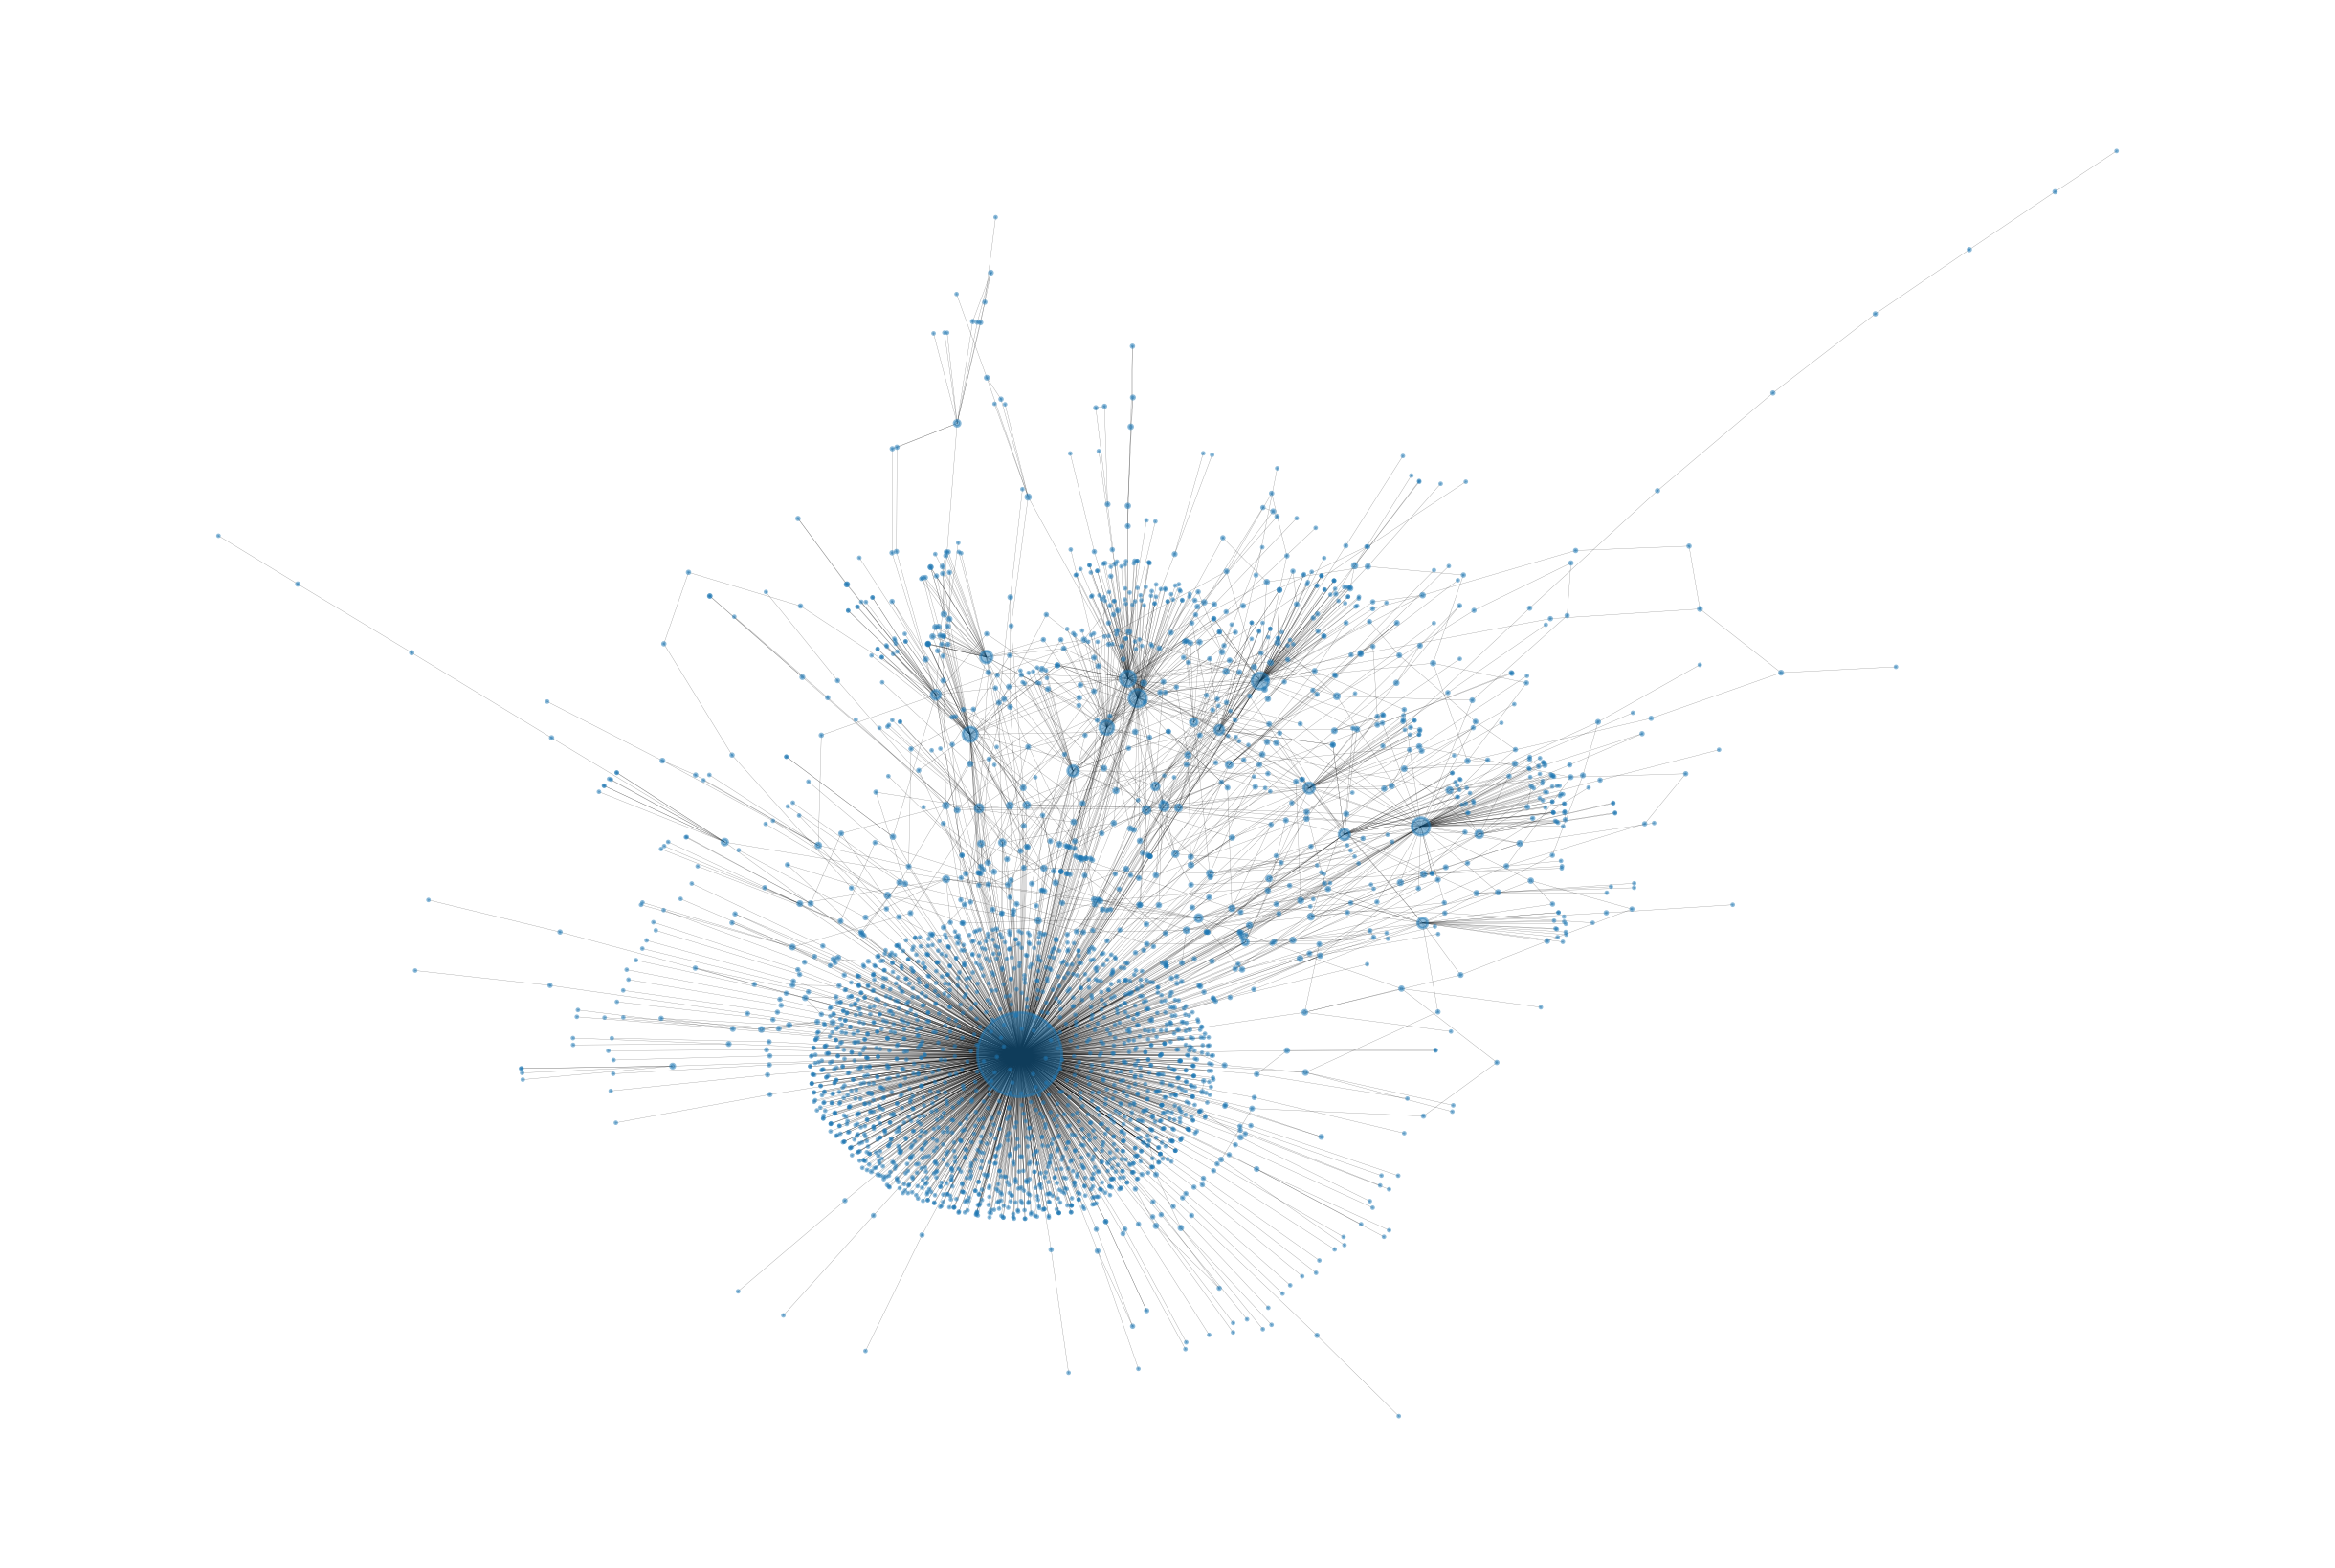

In [42]:
for i in range(len(b)):
    b[i].insert(0,a[i])

comment_network=pd.DataFrame(columns=['Sender','Reciever'])

for i in range(len(b)):
    for j in range(len(b[i])-1):
        new_row = { 'Sender':b[i][j], 'Reciever':b[i][j+1]}
        comment_network = comment_network.append(new_row, ignore_index=True)
comment_network=comment_network.drop_duplicates()

G=nx.Graph()
for i in range(len(comment_network)):
    G.add_edge(comment_network.iloc[i,0],comment_network.iloc[i,1]) 
pos = nx.spring_layout(G)
degree_dict = dict(nx.degree(G))

plt.figure(figsize=(12, 8), dpi=200)
nx.draw(G,pos, width=0.1,arrowsize=5,alpha=0.5, node_size= [v * 0.5 for v in degree_dict.values()])

In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

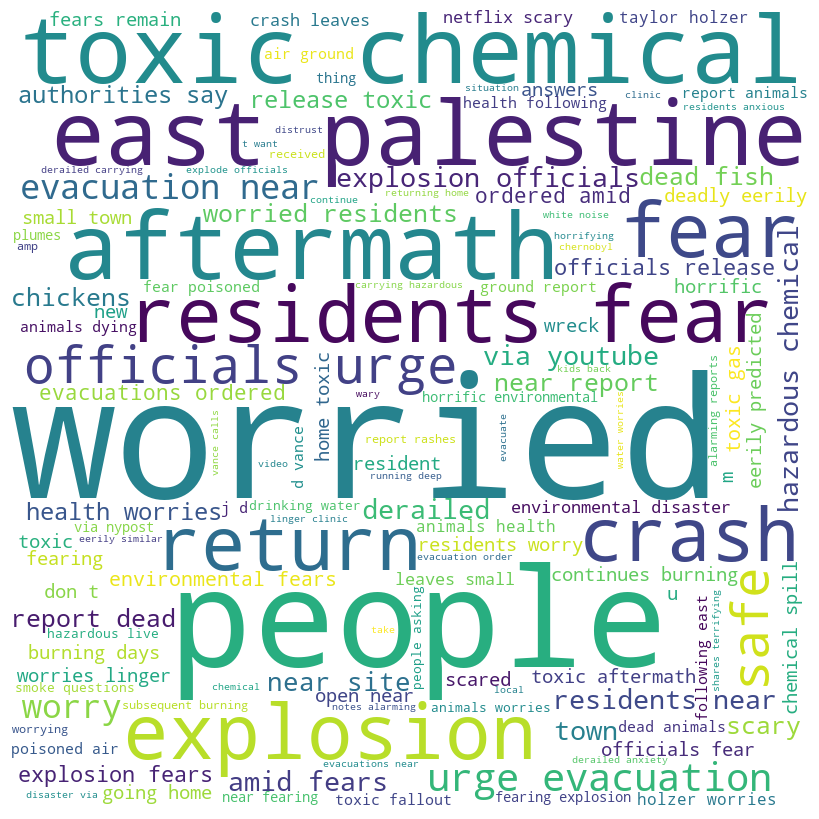

In [44]:
comment_words = ""
stopwords = set(STOPWORDS)
stopwords.add("s")
 
# iterate through the csv file
for val in data[data['emo_anx']>5].Text.apply(lambda x:re.sub("ohio|Ohio|train|Train|derailment|Derailment",'',x)):
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


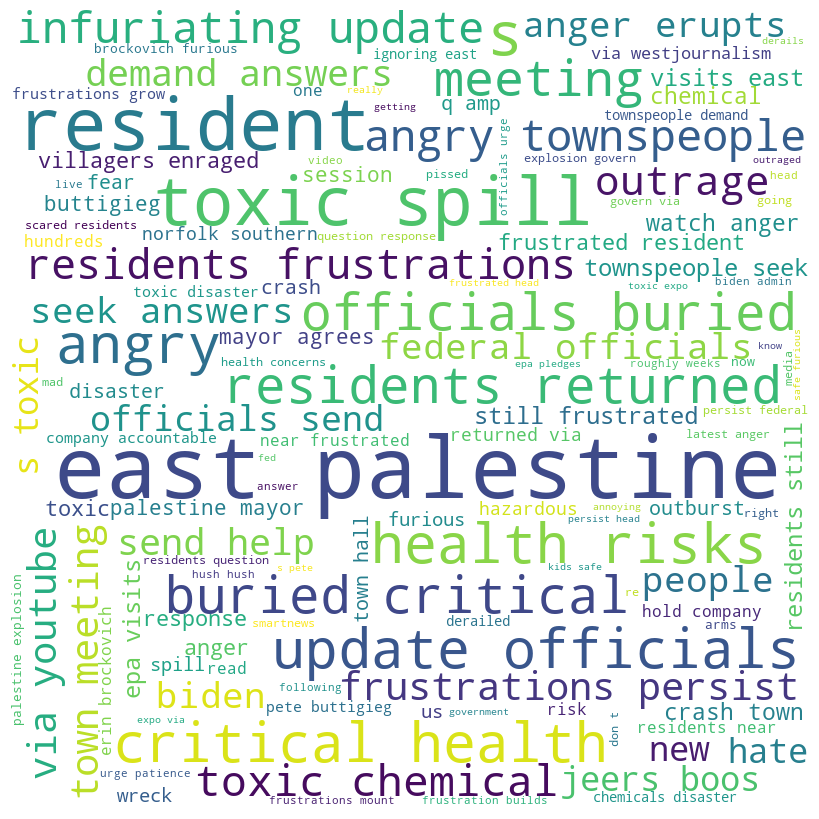

In [45]:
comment_words = ""
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in data[data['emo_anger']>5].Text.apply(lambda x:re.sub("ohio|Ohio|train|Train|derailment|Derailment",'',x)):
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [46]:
data = data.replace(0, np.NAN)
reg = data[['likeCount','emotion','politic','health']].dropna()
q1 = np.percentile(reg.likeCount, 25,interpolation='midpoint')
q3 = np.percentile(reg.likeCount, 75,interpolation='midpoint')
iqr = q3 - q1
reg = reg[(reg.likeCount>q1-1.5*iqr)&(reg.likeCount<q3+1.5*iqr)]

In [47]:
model1 = sm.NegativeBinomial.from_formula('likeCount ~ emotion + politic + health', data=reg).fit()
print(model1.summary())
print("AIC: %f BIC: %f" % (model1.aic, model1.bic))

Optimization terminated successfully.
         Current function value: 2.693971
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
                     NegativeBinomial Regression Results                      
Dep. Variable:              likeCount   No. Observations:                  445
Model:               NegativeBinomial   Df Residuals:                      441
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                0.005785
Time:                        13:08:35   Log-Likelihood:                -1198.8
converged:                       True   LL-Null:                       -1205.8
Covariance Type:            nonrobust   LLR p-value:                  0.002971
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6184      0.150     1

In [48]:
model2 = sm.Poisson.from_formula('likeCount ~ emotion + politic + health', data=reg).fit()
print(model2.summary())
print("AIC: %f BIC: %f" % (model2.aic, model2.bic))

Optimization terminated successfully.
         Current function value: 4.628093
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:              likeCount   No. Observations:                  445
Model:                        Poisson   Df Residuals:                      441
Method:                           MLE   Df Model:                            3
Date:                Wed, 01 Mar 2023   Pseudo R-squ.:                 0.02687
Time:                        13:08:35   Log-Likelihood:                -2059.5
converged:                       True   LL-Null:                       -2116.4
Covariance Type:            nonrobust   LLR p-value:                 1.739e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5366      0.060     25.803      0.000       1.420       1.653
emotion        0.1196      0.